In [75]:
import os 
import dill
from typing import Any
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import jax
import jax.numpy as jnp
from getdist import plots, MCSamples
import getdist
import glob
from astropy.io import fits
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median

plt.rc("text", usetex=False)
plt.rc("font", **{"family": "sans-serif", "serif": ["Palatino"]})
figSize = (12, 8)
fontSize = 20

# Notes
We are writing notes on [overleaf](https://www.overleaf.com/5766545661kjdgtrcsjkwc#1102fd). 

- Week 1: 10 - 16 June -> Literature review (Bayesian Statistics and Supernova Cosmology)
- Week 2: 17 - 23 June -> Literature review (Bayesian Statistics and Supernova Cosmology)
- Week 3: 24 - 30 June -> Data and Theory 
- Week 4: 01 - 07 July -> Data and Theory
- Week 5: 08 - 14 July -> Migrate to Jax and Numpyro
- Week 6: 15 - 21 July -> Migrate to Jax and Numpyro
- Week 7: 22 - 28 July -> Results/Conclusion
- Week 8: 29 - 04 July/August -> Results/Conclusion
- Week 9: 05 - 11 August -> Report/Presentation
- Week 10: 12 - 18 August -> Report/Presentation

# Data

In [64]:
data = pd.read_csv("data/jla_lcparams.txt", sep=" ", header=0)
covariance = np.load("data/covariance.npz")["arr_0"]
ndata = len(data)

In [66]:
print(f"Shape of covariance matrix: {covariance.shape}")

Shape of covariance matrix: (740, 740)


In [67]:
# data -> mb
# the redshift values -> zcmb
# log stellar mass values -> 3rdvar
# x1 values -> x1
# color values -> color

columns = ["mb", "zcmb", "3rdvar", "x1", "color"]
data_filtered = data[columns]
data_filtered.columns = ["mb", "redshift", "M_stellar", "X_1", "C"]

In [68]:
data_filtered.head()

,mb,redshift,M_stellar,X_1,C
0,23.001698,0.503084,9.517,1.273191,-0.012353
1,23.573937,0.580724,9.169,0.974346,-0.025076
2,22.960139,0.494795,11.580,-0.728837,-0.099683
3,22.398137,0.345928,10.821,-1.155110,-0.040581
4,24.078115,0.677662,8.647,0.618820,-0.039380


# Theory
We need some code here to compute the forward model (and we should be able to show an approximate theory and the data before proceeding with the next section). The cosmological and nuisance parameters are:

$$
\theta = (\Omega_{m},\,w_{0},\,M_{B},\,\delta M,\, \alpha,\, \beta)
$$

Therefore, we need a function which takes as input these parameters and outputs the apparent magnitude (the theory).

The luminosity distance is:

$$
D_{L}(z) = \dfrac{10^{5}(1+z)c}{H_{0}}\int_{0}^{z}\dfrac{1}{\sqrt{\Omega_{m}(1+z')^{3}+(1-\Omega_{m})(1+z')^{3(w_{0}+1)}}}\,dz'
$$

where $c=299792.458\,\textrm{km}\,\textrm{s}^{-1}$ is the speed of light and $H_{0}=70.0\,\textrm{km}\,\textrm{s}^{-1}\,\textrm{Mpc}^{-1}$ is the Hubble constant. 

The apparent magnitude in terms of the light-curve stretch, $X_{1}$ and colour at maximum brightness, $C$ is 

$$
m_{B} = 5\,\textrm{log}_{10}\,D_{L}(z) + M_{B} + \delta M\Theta(M_{\textrm{stellar}}-10^{10}M_{\odot}) -\alpha X_{1} + \beta C
$$

where $\Theta$ is the Heaviside function and $M_{B}$ is the absolute magnitude. 



In [69]:
def compute_app_mag(redshift, m_stellar, x_1, color, cosmo_params, nuisance_params):
    """
    Compute the apparent magnitude based on cosmological parameters, redshift, and nuisance parameters.

    Parameters:
    -----------
    redshift : float
        The redshift of the object.
    m_stellar : float
        The stellar mass of the object.
    x_1 : float
        The stretch parameter for the supernova.
    color : float
        The color parameter for the supernova.
    cosmo_params : tuple
        A tuple containing the cosmological parameters:
        - omega_matter (float): The matter density parameter.
        - w_0 (float): The equation of state parameter for dark energy.
    nuisance_params : tuple
        A tuple containing the nuisance parameters:
        - m_b (float): The base magnitude.
        - delta_m (float): The change in magnitude for stellar mass > 10.
        - alpha (float): The stretch correction parameter.
        - beta (float): The color correction parameter.

    Returns:
    --------
    float
        The apparent magnitude computed from the cosmological and nuisance parameters.

    Notes:
    ------
    The function computes the apparent magnitude by first calculating the cosmological component,
    which is determined by integrating over a redshift grid using the trapezoidal rule. The nuisance
    component is then added, where the base magnitude may be adjusted by delta_m if the stellar mass
    is greater than 10. The stretch and color corrections are also applied to the nuisance component.
    """
    # unpack the parameters
    omega_matter, w_0 = cosmo_params
    m_b, delta_m, alpha, beta = nuisance_params

    # cosmological part
    factor = 10**5 * (1.0 + redshift) * 299792.458 / 70.0
    zgrid = jnp.linspace(0.0, redshift, 1000)
    fgrid = 1.0 / jnp.sqrt(
        omega_matter * (1 + zgrid) ** 3
        + (1 - omega_matter) * (1 + zgrid) ** (3 * (1 + w_0))
    )
    cosmology = 5.0 * jnp.log10(factor * jnp.trapezoid(fgrid, zgrid))

    # nuisance part
    def use_delta_m(m_b):
        return m_b + delta_m

    def skip_delta_m(m_b):
        return m_b

    nuisance = (
        jax.lax.cond(m_stellar > 10, use_delta_m, skip_delta_m, m_b)
        - alpha * x_1
        + beta * color
    )

    return cosmology + nuisance

Here, I am setting three of the nuisance parameters to zero, so we can just visualise the smooth function for the apparent magnitude.

In [61]:
cosmo_params = [0.3, -1.0]
nuisance_params = [-19.0, 0.0, 0.0, 0.0]
inputs = data_filtered[["redshift", "M_stellar", "X_1", "C"]].values

Here, we are computing the theoretical apparent magnitude for a single supernovae at a fixed set of cosmological and nuisance parameters. 

In [62]:
compute_app_mag(*inputs[0], cosmo_params, nuisance_params)

Array(23.277206, dtype=float32)

Here, we are using calculating the theoretical apparent magnitude for all the supernova at a fixed set of cosmological and nuisance parameters.

In [52]:
def compute_theory(inputs):
    """
    Compute the theoretical apparent magnitudes for a set of supernovae using cosmological and nuisance parameters.

    Parameters:
    -----------
    inputs : jax.numpy.ndarray
        An N x 4 array where N is the number of supernovae (in this case, 740). Each row corresponds to a supernova and contains:
        - redshift (float): The redshift of the supernova.
        - m_stellar (float): The stellar mass of the supernova.
        - x_1 (float): The stretch parameter for the supernova.
        - color (float): The color parameter for the supernova.

    Returns:
    --------
    jax.numpy.ndarray
        An array of length N containing the apparent magnitudes computed from the given inputs and pre-defined cosmological and nuisance parameters.

    Notes:
    ------
    This function processes an array of inputs, each representing a supernova, and computes the apparent magnitude for each one
    using the `compute_app_mag` function. The `compute_app_mag` function is called with the individual parameters unpacked from each row
    of the `inputs` array along with the global cosmological and nuisance parameters.
    """
    redshift, m_stellar, x_1, color = inputs
    return compute_app_mag(
        redshift, m_stellar, x_1, color, cosmo_params, nuisance_params
    )

In [53]:
predicted_magnitudes = jax.lax.map(compute_theory, inputs)

Sort the redshift so we can use it to interpolate smoothly between the maximum and maximum.

In [54]:
idx = np.argsort(data_filtered["redshift"].values)
z_sorted = data_filtered["redshift"].values[idx]
mb_sorted = predicted_magnitudes[idx]

Create a fine grid of redshift and interpolate.

In [12]:
z_grid = jnp.linspace(z_sorted[0], z_sorted[-1], 1000)
mb_grid = jnp.interp(z_grid, z_sorted, mb_sorted)

Here, we get the error on the magnitudes (which is simply the square root of the diagonal of the covariance matrix). 

We also compute the correlation matrix (between -1 and 1). 

In [13]:
sigma = jnp.sqrt(jnp.diag(covariance))
correlation = np.zeros_like(covariance)

for i in range(ndata):
    for j in range(ndata):
        correlation[i, j] = covariance[i, j] / np.sqrt(
            covariance[i, i] * covariance[j, j]
        )

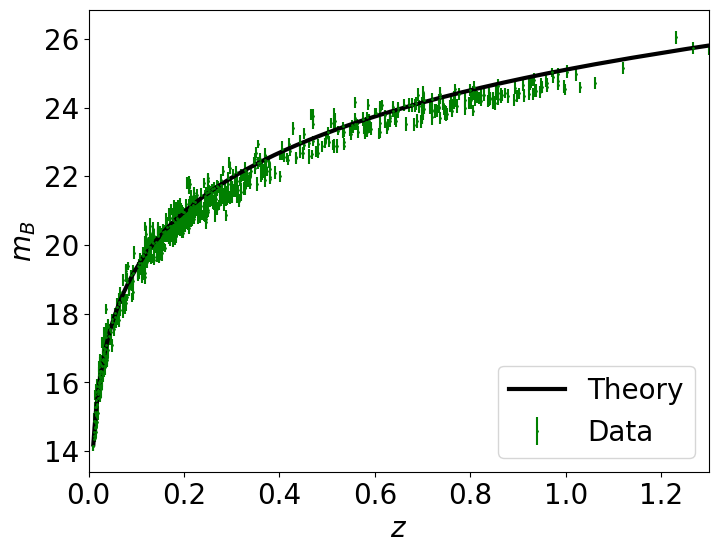

In [19]:
plt.figure(figsize=(8, 6))
plt.errorbar(
    z_sorted,
    data_filtered["mb"].values[idx],
    yerr=sigma,
    fmt="go",
    markersize=1,
    label="Data",
)
plt.plot(z_grid, mb_grid, c="k", lw=3, label="Theory")
plt.xlim(0.0, max(z_grid))
plt.ylabel(r"$m_{B}$", fontsize=fontSize)
plt.xlabel(r"$z$", fontsize=fontSize)
plt.tick_params(axis="x", labelsize=fontSize)
plt.tick_params(axis="y", labelsize=fontSize)
plt.legend(loc="lower right", prop={"family": "sans-serif", "size": 20})
plt.show()

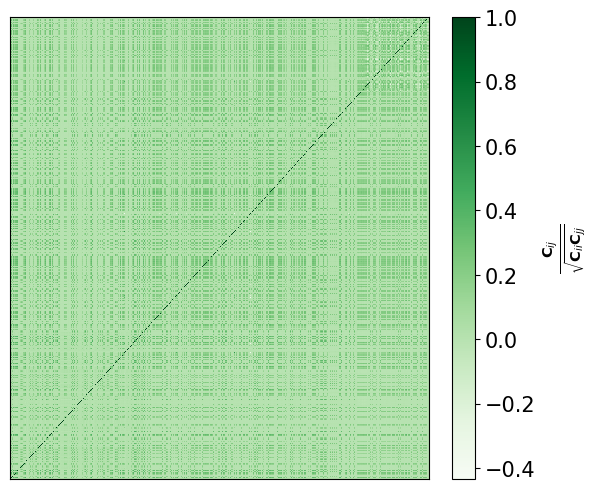

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))
heatmap = ax.pcolor(correlation, cmap=plt.cm.Greens)
cbar = plt.colorbar(heatmap, fraction=0.05)
cbar.set_label(
    r"$\frac{\mathbf{C}_{ij}}{\sqrt{\mathbf{C}_{ii}\mathbf{C}_{jj}}}$", size=15
)
cbar.ax.tick_params(labelsize=15)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
plt.show()

# Inference
We need some code here to do the inference of the parameters. There is a nice introduction to `numpyro` [here](https://dfm.io/posts/intro-to-numpyro/). We also need priors on the parameters. Let us use the following:

- $\Omega_{m}\sim U[0.001, 0.6]$
- $w_{0}\sim U[-1.5, 0.0]$
- $M_{B}\sim \mathcal{N}(-19.0, 1.0)$  
- $\delta M \sim \mathcal{N}(-0.05, 1.0)$
- $\alpha \sim \mathcal{N}(0.125, 1.0)$
- $\beta \sim \mathcal{N}(2.6, 1.0)$

Some demo of samplers can be found here: https://chi-feng.github.io/mcmc-demo/app.html

In [21]:
def numpyro_model(data, covariance, inputs):
    
    # Priors for the cosmological parameters
    Omega_m = numpyro.sample('Omega_m', dist.Uniform(0.001, 0.6))
    w_0 = numpyro.sample('w_0', dist.Uniform(-1.50, 0.0))
    
    # Priors for the nuisance parameters
    abs_mag = numpyro.sample('abs_mag', dist.Normal(-19.0, 1.0))
    delta_m = numpyro.sample('delta_m', dist.Normal(-0.05, 1.0))
    alpha = numpyro.sample('alpha', dist.Normal(0.125, 1.0))
    beta = numpyro.sample('beta', dist.Normal(2.6, 1.0))

    # Pack parameters
    cosmo_params = (Omega_m, w_0)
    nuisance_params = (abs_mag, delta_m, alpha, beta)
    
    def compute_theory(inputs):
        redshift, m_stellar, x_1, color = inputs
        return compute_app_mag(redshift, m_stellar, x_1, color, cosmo_params, nuisance_params)
    theory = jax.lax.map(compute_theory, inputs)
    
    # the sampling distribution
    sampling_distribution = dist.MultivariateNormal(theory, covariance_matrix=covariance)
    numpyro.sample("obs", sampling_distribution, obs=data)

In [22]:
NWARMUP = 500
NSAMPLES = 15000
EPS = 0.1
NCHAIN = 2
TREE_DEPTH = 5 

In [23]:
nuts_kernel = NUTS(numpyro_model, step_size=EPS, init_strategy=init_to_median, dense_mass=True, max_tree_depth=TREE_DEPTH)

In [24]:
mcmc_nuts = MCMC(nuts_kernel, 
                 num_warmup=NWARMUP, 
                 num_samples=NSAMPLES, 
                 num_chains=NCHAIN, 
                 chain_method="vectorized",
                 progress_bar=True)

In [25]:
mcmc_nuts.run(jax.random.PRNGKey(253), data_filtered['mb'].values, covariance, inputs)

sample: 100%|███████████████████████████| 15500/15500 [1:18:05<00:00,  3.31it/s]


Some functions to save and load the MCMC object.

In [70]:
def dill_save(file: Any, folder: str, fname: str) -> None:
    """Stores a file, for example, MCMC samples.
    Args:
        file (Any): the file we want to store.
        folder (str): folder where we want to store the file
        fname (str): the name of the file.
    """
    os.makedirs(folder, exist_ok=True)
    # use compressed format to store data
    path = os.path.join(folder, fname)
    with open(path + ".pkl", "wb") as dummy:
        dill.dump(file, dummy)


def dill_load(folder: str, fname: str) -> Any:
    """Reads a file from a folder.
    Args:
        folder(str): the name of the folder.
        file (str): the name of the file.
    Returns:
        Any: the stored file
    """
    path = os.path.join(folder, fname)
    with open(path + ".pkl", "rb") as dummy:
        file = dill.load(dummy)
    return file

In [71]:
# dill_save(mcmc_nuts, 'mcmcsamples', 'experiment_1')
# nuts_object = dill_load('mcmcsamples', 'experiment_1')
# nuts_object.get_samples()

# Posterior Plot and Analysis
We need some code here to plot the results. There is a nice tutorial of how to generate beautiful plots [here](https://getdist.readthedocs.io/en/latest/plot_gallery.html).

In [72]:
from getdist import plots, MCSamples
from matplotlib import cm 
import getdist 

color1 = "#50C878" 
settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3}

In [73]:
samples = mcmc_nuts.get_samples()
columns = ['Omega_m', 'w_0', 'abs_mag', 'delta_m', 'alpha', 'beta']
mcmc_samples = np.vstack([samples[c] for c in columns]).T

In [81]:
ndim = len(columns)
names = ["x%s"%i for i in range(ndim)]
labels = [
    r"\Omega_{m}",
    r"w_{0}",
    r"M",
    r"\delta M",
    r"\alpha",
    r"\beta"]
getdist_samples = MCSamples(samples=mcmc_samples,names = names, labels = labels, ranges={'x0':(0.0, None)}, label = 'JLA (NUTS)', settings = settings)

Removed no burn in


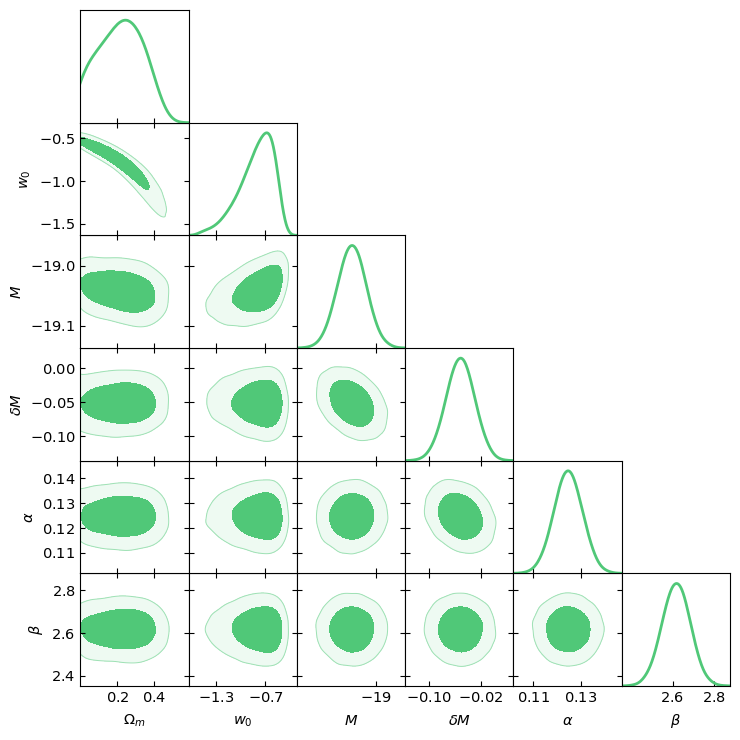

In [82]:
G = plots.getSubplotPlotter(subplot_size=1.25)
G.settings.solid_contour_palefactor = 0.9
G.settings.alpha_filled_add = 0.5
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.fontsize = 35  
G.settings.legend_fontsize = 15
getdist_samples.updateSettings({"contours": [0.68, 0.95]})
G.triangle_plot([getdist_samples],
    filled=[True],
    contour_colors=[color1],
    contour_lws=[2],
    contour_ls=["-"],
)
# plt.savefig('triangle_plot_jla_nuts.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

In [32]:
mcmc_nuts.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_m      0.22      0.11      0.22      0.02      0.39   4302.12      1.00
   abs_mag    -19.04      0.02    -19.04    -19.08    -19.00  15969.71      1.00
     alpha      0.12      0.01      0.12      0.12      0.13  28020.27      1.00
      beta      2.62      0.07      2.62      2.51      2.73  21335.65      1.00
   delta_m     -0.05      0.02     -0.05     -0.09     -0.02  20625.23      1.00
       w_0     -0.81      0.21     -0.77     -1.13     -0.51   3836.23      1.00

Number of divergences: 0
